# Прогнозирование вероятности оттока пользователей для фитнес-центров

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-пользователей" data-toc-modified-id="Построение-модели-прогнозирования-оттока-пользователей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока пользователей</a></span></li><li><span><a href="#Кластеризация-пользователей" data-toc-modified-id="Кластеризация-пользователей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация пользователей</a></span></li><li><span><a href="#Выводы-и-базовые-рекомендации-по-работе-с-клиентами" data-toc-modified-id="Выводы-и-базовые-рекомендации-по-работе-с-клиентами-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и базовые рекомендации по работе с клиентами</a></span></li></ul></div>

**Задача исследования**

На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей, подготовить план действий по удержанию клиентов.

**Ход исследования:**
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  1. выделить целевые группы клиентов;
  2. предложить меры по снижению оттока;
  3. определить другие особенности взаимодействия с клиентами.

## Обзор данных

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, roc_auc_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:,.2f}'.format)

Загрузим файл с данными, проверим на наличие дубликатов, пропусков, проверим типы данных.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
def info (df):         # функция для получения первичной информации о датасете
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(df.head(5))
    print(f'В таблице строк: {df.shape[0]}, столбцов: {df.shape[1]} ')
    print('Количество дубликатов:', df.duplicated().sum())
    print('Процент дубликатов: ', "{:.2%}".format((df.duplicated().sum()/df.shape[0])))
    tbl = pd.concat([df.dtypes, df.isna().sum(), round((df.isna().mean()*100),2), ], axis=1, 
                   keys=["Тип данных", "Кол-во пропусков", "% пропусков", ])
    display(tbl)

info(df)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


В таблице строк: 4000, столбцов: 14 
Количество дубликатов: 0
Процент дубликатов:  0.00%


,Тип данных,Кол-во пропусков,% пропусков
gender,int64,0,0.00
Near_Location,int64,0,0.00
Partner,int64,0,0.00
Promo_friends,int64,0,0.00
Phone,int64,0,0.00
Contract_period,int64,0,0.00
Group_visits,int64,0,0.00
Age,int64,0,0.00
Avg_additional_charges_total,float64,0,0.00
Month_to_end_contract,float64,0,0.00


**Описание данных**

- 'Churn' — факт оттока в текущем месяце;
- Данные пользователя за предыдущий до проверки факта оттока месяц:
  - 'gender' — пол
  - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
  - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
  - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
  - 'Phone' — наличие контактного телефона
  - 'Age' — возраст
  - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)


- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
  - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
  - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
  - 'Group_visits' — факт посещения групповых занятий
  - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
  - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
  - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон


**Вывод**

В таблице содержится 4000 записей о посетителях фитнес-центров. Учитывая эмпирические правила, этого количества наблюдений достаточно для проведения исследования и машинного обучения. Пропусков и дубликатов не обнаружено. Типы данных в колонках и нзвания колонок соответствуют содержимому. Можно перейти к исследовательскому анализу данных.


## Исследовательский анализ данных (EDA)

Проведем исследование данных, чтобы сформулировать первые гипотезы относительно качества данных и аномалий в них. Посмотрим, какие признаки станут ключевыми для модели, а какими можно пренебречь. Проанализируем средние значения и стандартные отклонения, выбросы. Определим, нужно ли создание новых признаков. Посмотрим на типы распределения признаков и их корреляцию.

- Все признаки в нашем датасете являются количественными. Преобразований здесь не требуется. 
- Целевая переменная (Churn) не имеет временной структуры, задача прогнозирования временного ряда не стоит. 


Изучим средние значения и стандартные отклонения данных датасета:

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Можно сказать, что разброс в данных не большой. Доля оттока около 27%. Возраст клиентов от 18 до 41 года. В среднем клиенты посещают фитнес около 4 месяцев, но есть небольшая часть тех, кто ходит больше 2 лет. Перед тем как делать выводы посмотрим распределение на графиках.

По нашему мнению, признаков достаточно для построения модели, дополнительно создавать новые признаки не будем.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток (колонка 1) и тех, кто остался (колонка 0). 

In [5]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


Можно отметить, что почти по каждому признаку есть различия у двух групп клиентов. На отток не влияет только пол клиента и наличие контактного телефона.Наиболее заметные различия в средних значениях параметров `Contract_period`, `Month_to_end_contract`, `Lifetime`. У тех, кто не попал в отток, показатели выше среднего, у остальных ниже или близко к минимальным.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

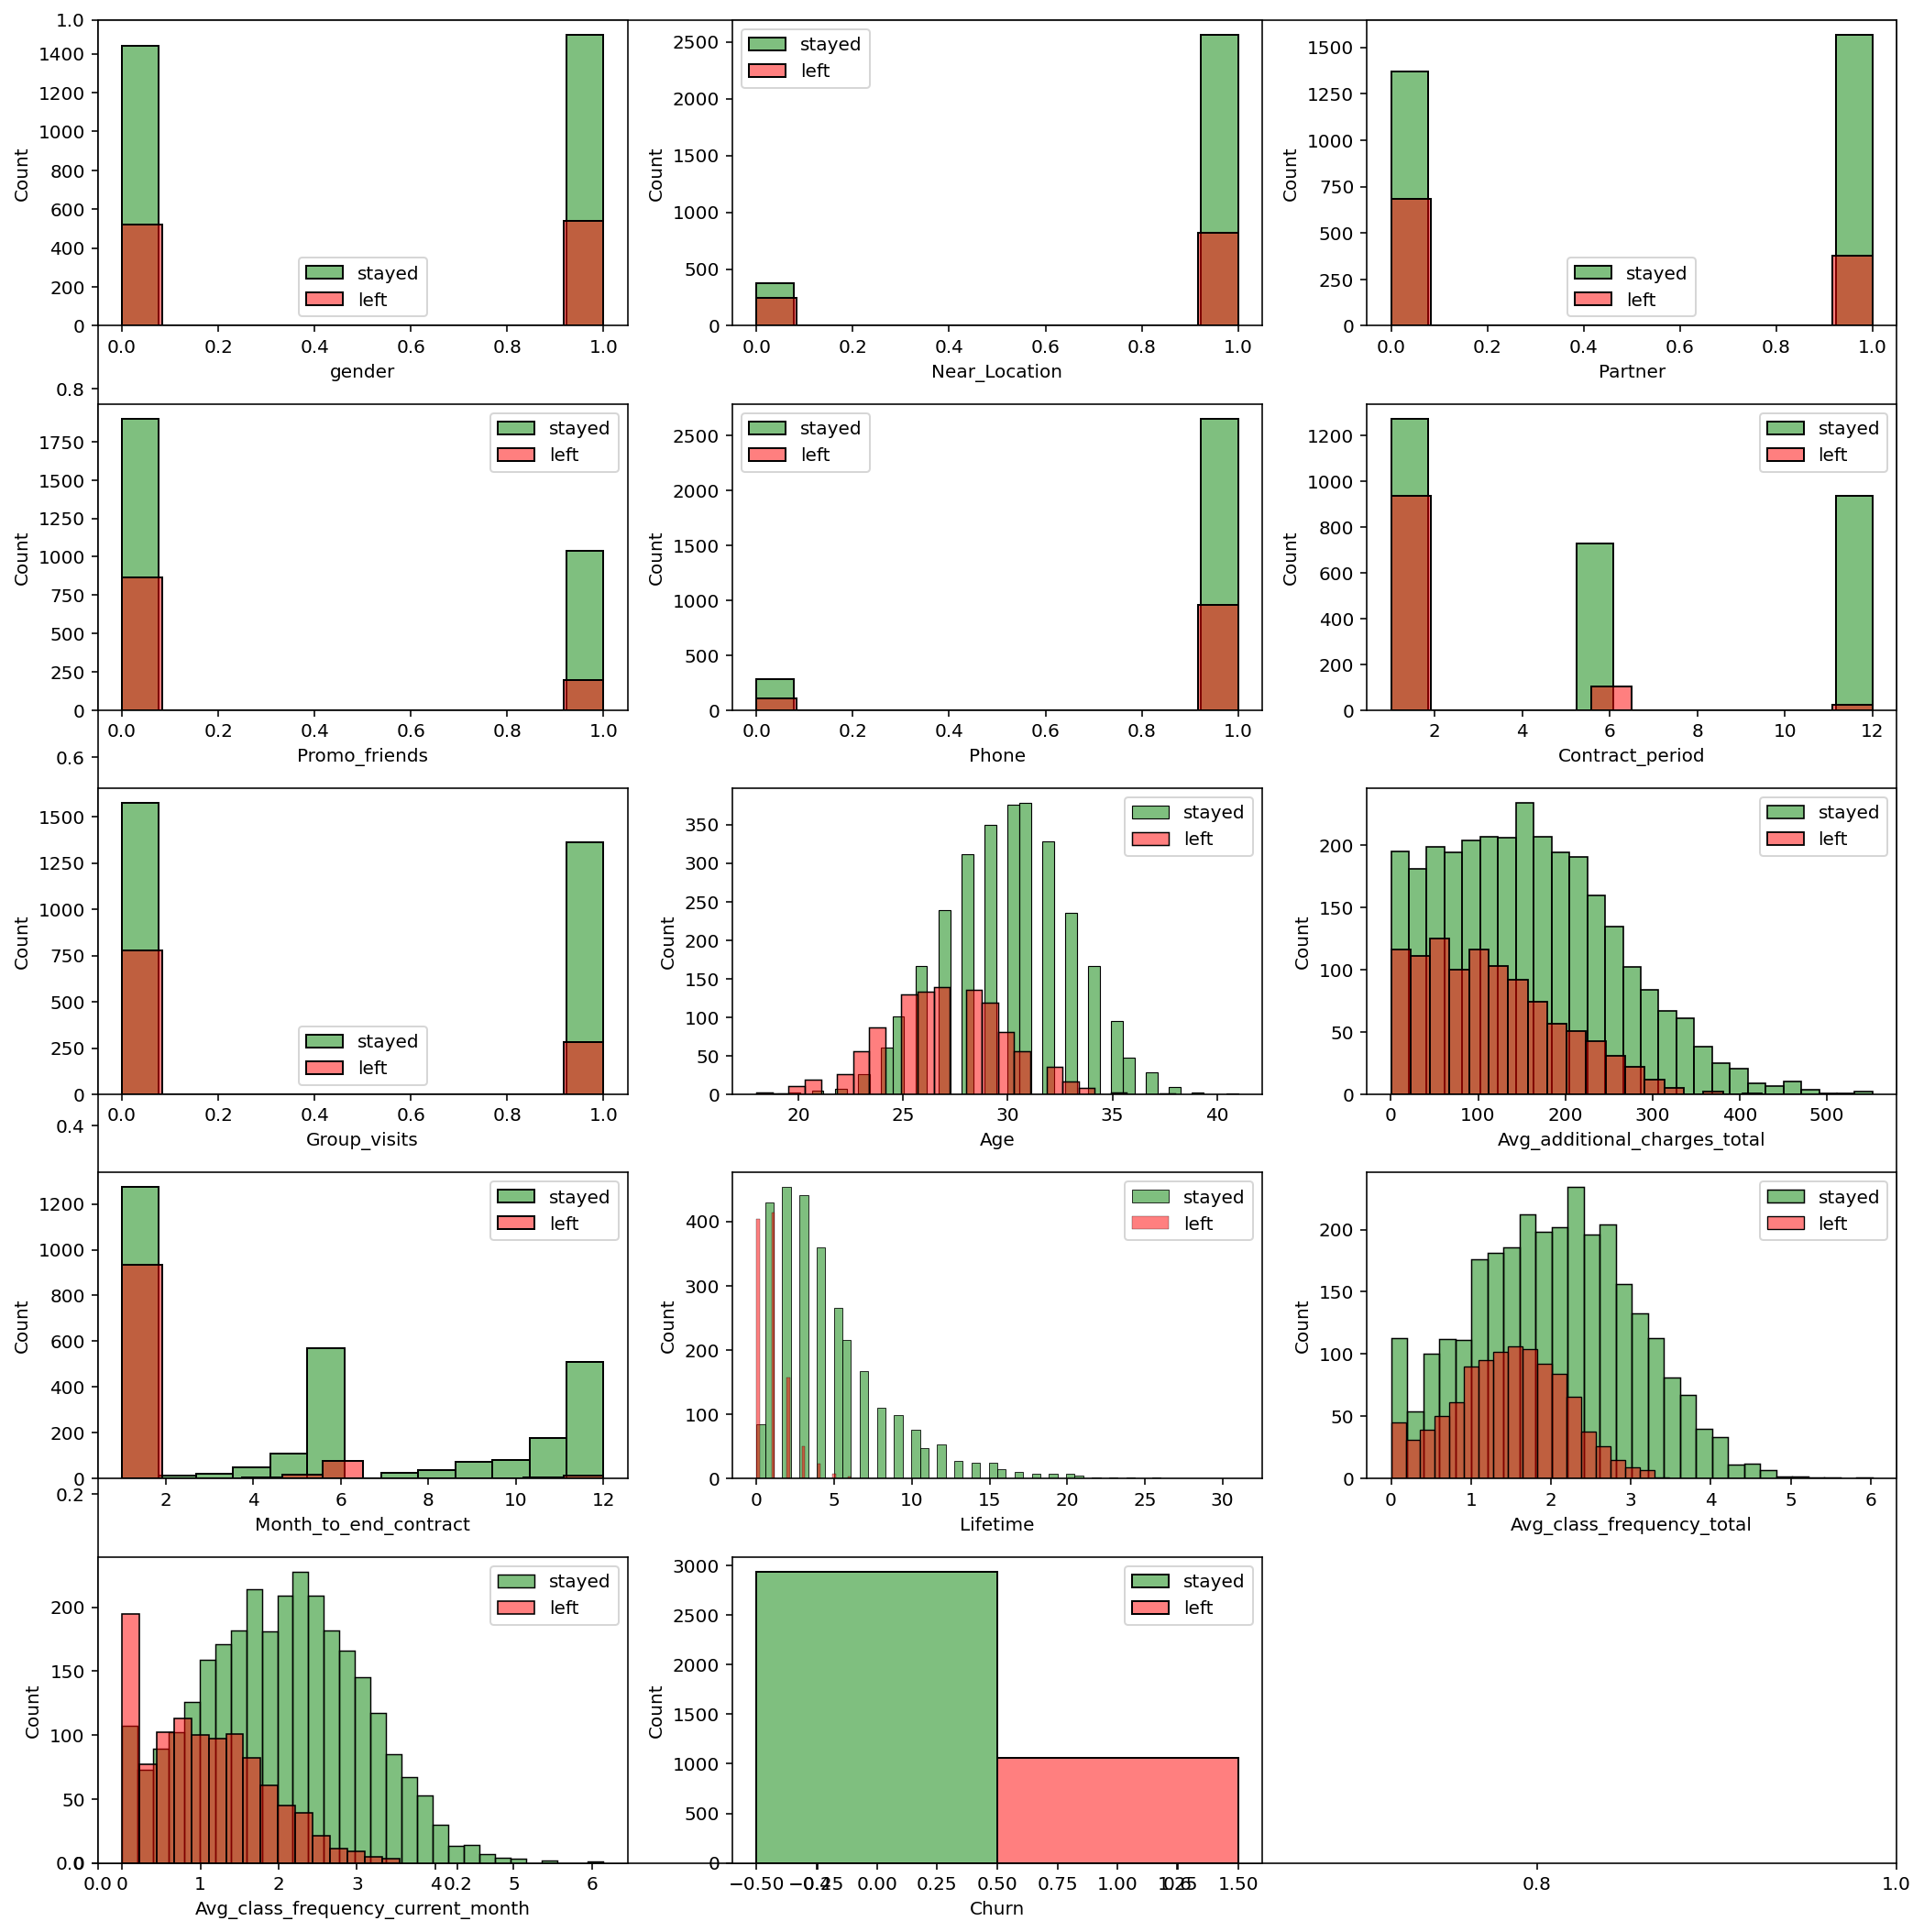

In [6]:
fig, ax = plt.subplots(figsize = (15, 15))
for i, column in enumerate(df.columns):
    ax=fig.add_subplot(5, 3, i+1)
    sns.histplot(df[df['Churn'] == 0][column], color='green', alpha=0.5, ax=ax)
    sns.histplot(df[df['Churn'] == 1][column], color='red', alpha=0.5, ax=ax)
    plt.legend(('stayed','left'), fontsize = 10)
plt.tight_layout()  

По графикам можно сделать предварительные выводы:

- Существенно не влияют на отток такие параметры, как пол, расположение, наличие телефона.
- Чаще уходят люди моложе 35 лет, чей срок окончания абонемента 1 месяц, чей общий срок контракта 1 месяц, кто не посещает групповые занятия, не был приглашен по акции и не являются сотрудниками компании-партнёра клуба.
- Распределение `Age` можно считать нормальным. 
- Распределения `Lifetime` и `Avg_additional_charges_total` усечены слева, т.к. среднее расположено ближе к левой границе. Большинство клиентов, которые ушли, посещали фитнес не более 3 месяцев. И ушедшие и оставшиеся клиенты примерно одинаково платили за дополнительные услуги. 
- Распеределения `Avg_class_frequency_total` и `Avg_class_frequency_current_month` имеют пики у левой границы. Те, кто не посещал фитнес в предыдущем месяце, уходят чаще остальных. 
- Значимых выбросов не обнаружено.

Построим и отобразим матрицу корреляций

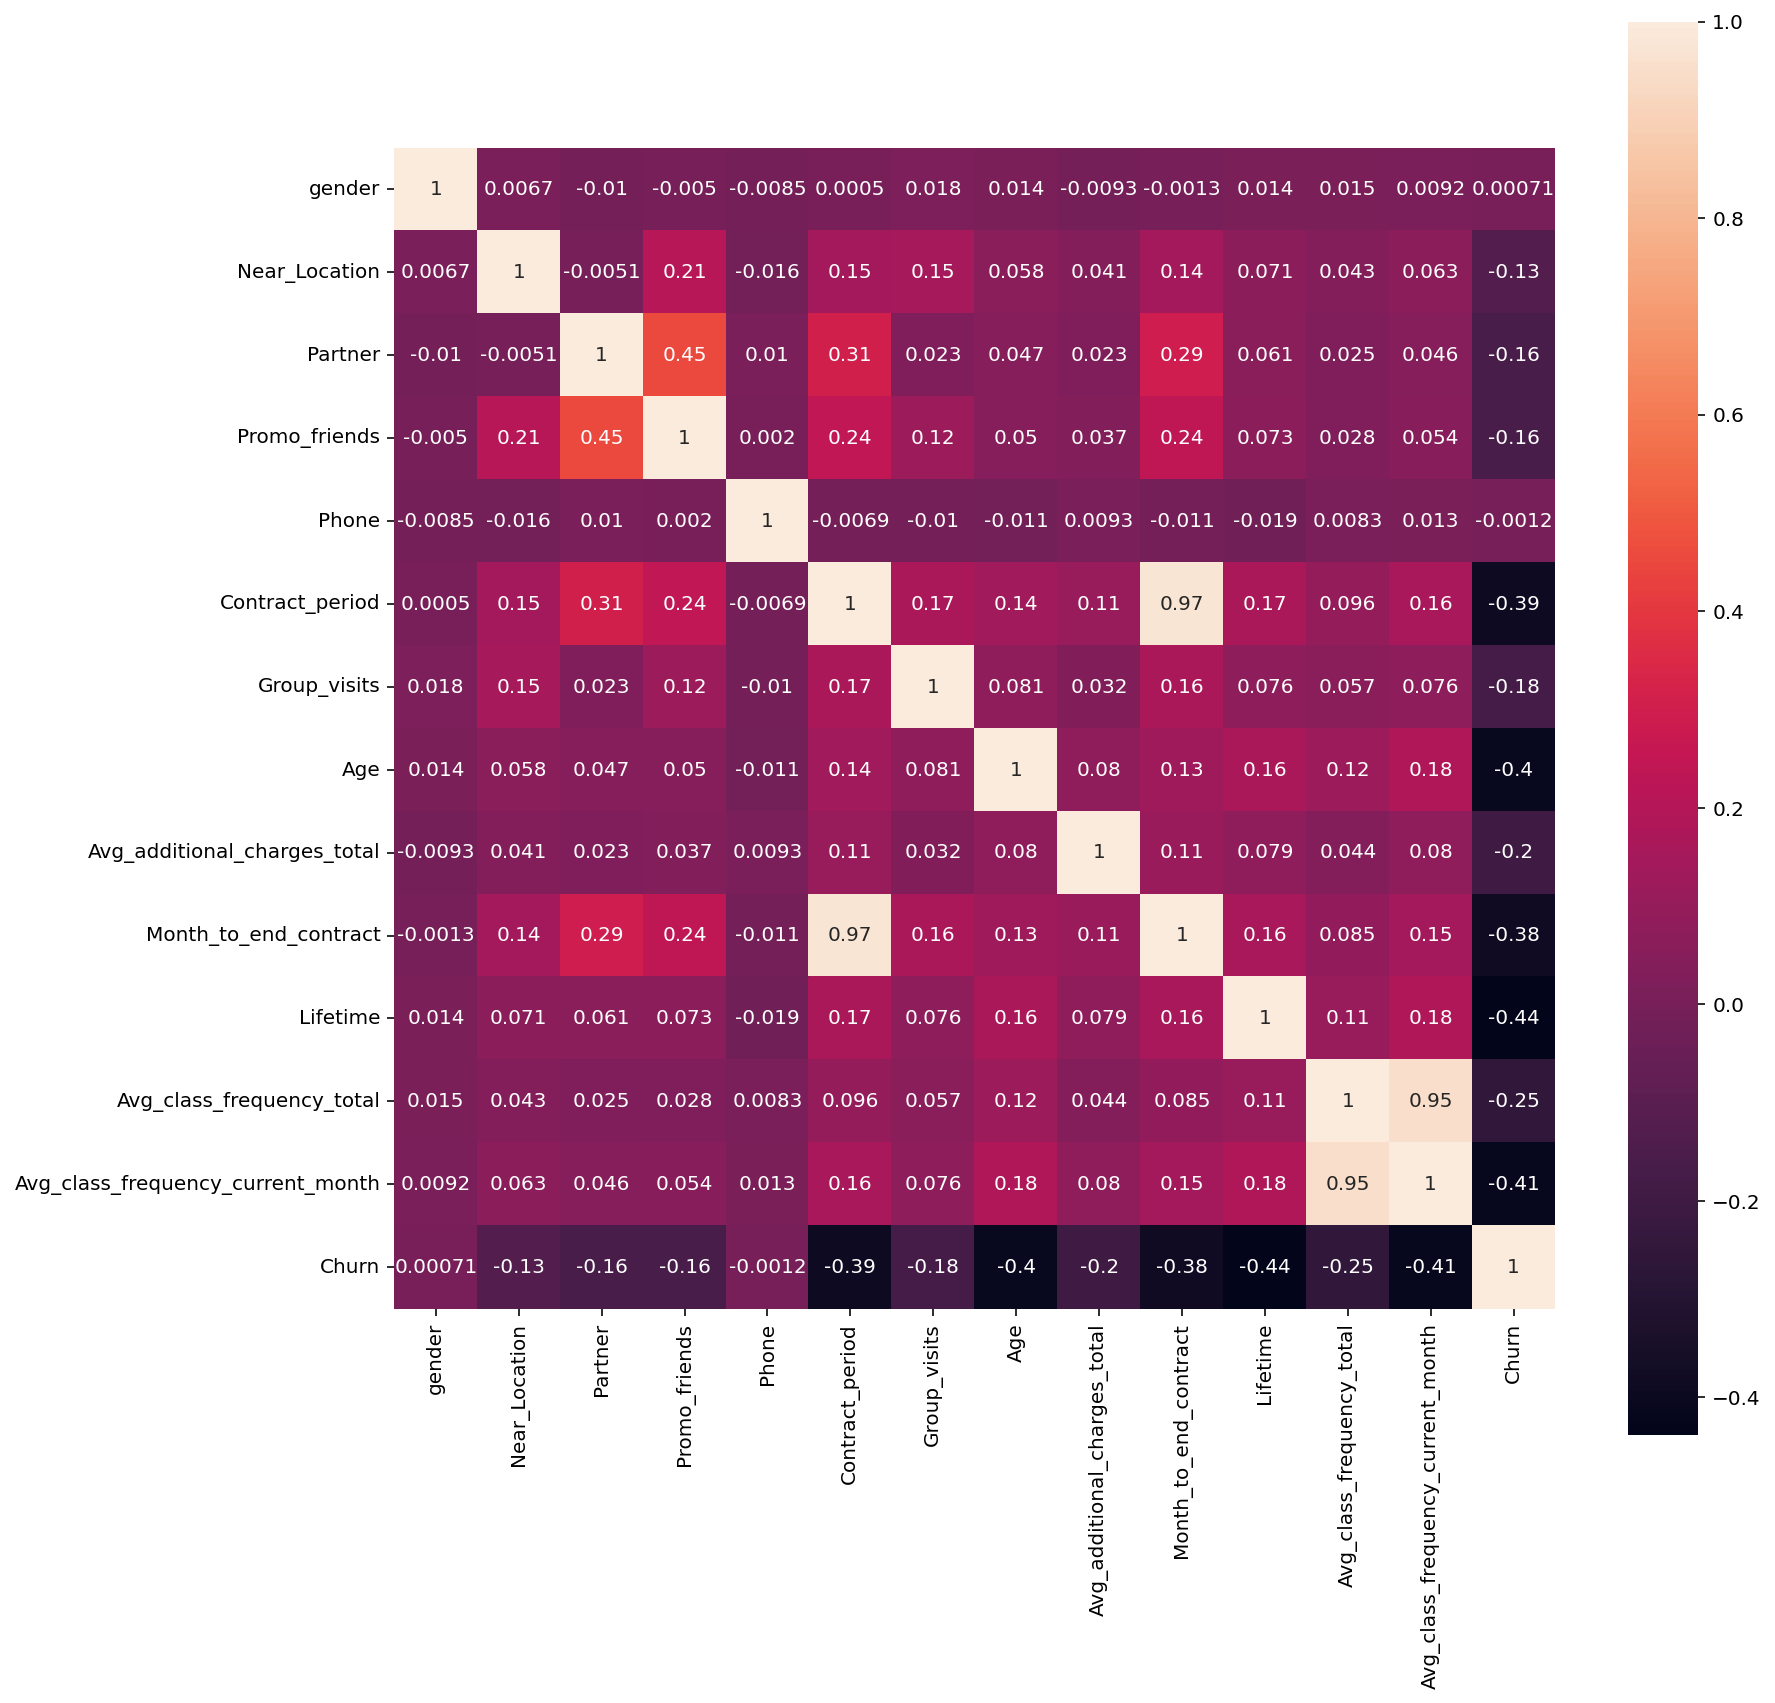

In [7]:
plt.figure(figsize = (13,13))

corr_m = df.corr()
sns.heatmap(corr_m, square = True, annot = True, ) 
plt.show()


По матрице можно сказать:
- нет признаков, которые прямо влияют на целевую переменную (корреляция не более чем на 0,9 по модулю)
- есть признаки, сильно коррелирующие между собой: Avg_class_frequency_total и Avg_class_frequency_current_month, Contract_period и Month_to_end_contract (корреляция более чем на 0,9 по модулю). В данном проекте убирать их не будем. 


**Выводы**

- исходя из графиков, наиболее ценными для модели могут быть признаки: Age, Contract_period, Month_to_end_contract, Lifetime, Avg_class_frequency_current_month
- наименьшее влияние оказываю: пол, расположение, наличие телефона.  
- чаще уходят люди моложе 35 лет, чей срок окончания абонемента 1 месяц, чей общий срок контракта 1 месяц, кто не посещает групповые занятия, не был приглашен по акции и не являются сотрудниками компании-партнёра клуба.

## Построение модели прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.

Посмотрим, как соотносятся классы набора данных.

In [8]:
df['Churn'].value_counts().to_frame()

,Churn
0,2939
1,1061


Объектов класса `0` в 2.7 раз больше, чем объектов класса `1`, значит классы не сбаланстрованны. Воспользуемся в дальнейшем корректировкой порога (threshold).

In [9]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

Разделим модель на обучающую и валидационную выборки. Применим случайное разбиение, т.к. нам не важно влияние соседних наблюдений друг на друга. Соотношение размеров выборок 80:20 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

Стандартизируем данные

In [11]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке способом **логистической регрессии**

In [12]:
log_model = LogisticRegression(solver='liblinear') # задаем алгоритм модели 
log_model.fit(X_train_st, y_train)
log_predictions = log_model.predict(X_test_st)  # рассчитаем прогноз класса после обучения модели
log_probabilities = log_model.predict_proba(X_test_st)[:,1]  # рассчитаем вероятность принадлежности объекта к второму классу

Оценим на валидационной выборке метрики **accuracy** (долю правильных ответов), **precision** (точность) и **recall** (полноту) нашей модели на основе **логистической регресии**.

In [13]:
print('Метрики для модели логистической регрессии с порогом по умолчанию')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, log_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, log_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, log_predictions)))

Метрики для модели логистической регрессии с порогом по умолчанию
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


Метрика accuracy зависит от соотношения классов, поэтому в условиях несбалансированных выборок, как в нашем случае, более показательны метрики precision и recall.

Проверим алгоритм логистической регрессии метрикой `roc_auc` (площадь под кривой ошибок)

In [14]:
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, log_probabilities)))

ROC_AUC: 0.97


Показатель ROC_AUC 0.97 является приемлемым.

В качестве эксперимента скорректируем порог (трешхолд), заново рассчитаем вектор финальных прогнозов и сравним с метриками, полученными при автоматическом расчёте классов методом predict().

In [15]:
log_threshold = 0.4  # задаем порог

# на основании вероятностей и соотношения классов считаем predict
custom_log_predictions = [0 if i < log_threshold else 1 for i in log_probabilities]

print('Метрики для модели логистической регрессии с кастомным порогом')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, custom_log_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, custom_log_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, custom_log_predictions)))

Метрики для модели логистической регрессии с кастомным порогом
Accuracy: 0.92
Precision: 0.82
Recall: 0.86


Улучшилась метрика recall, однако ухудшилась Precision. В данном случае изменение порога особенных преимуществ не дало.

Обучим модель на train-выборке способом **случайный лес**

In [16]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  
rf_model.fit(X_train_st, y_train)                 
rf_predictions = rf_model.predict(X_test_st)         
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

Оценим на валидационной выборке метрики **accuracy** (долю правильных ответов), **precision** (точность) и **recall** (полноту) нашей модели на основе **случайного леса**.

In [17]:
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


Проверим алгоритм случайного леса метрикой `roc_auc`

In [18]:
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

ROC_AUC: 0.97


Показатель ROC_AUC такой же как у логистической регрессии.

**Оценка качества результатов и выбор лучшей модели**

Ключевым параметром для прогнозирования оттока является доля правильных ответов для целевого класса, т.е. метрика `recall`. То есть, нам важно совершить меньше ошибок предсказания, что клиент от нас уйдет — нужно выявить клиентов склонных к оттоку, и принимать меры по их удержанию. Учитывая это, лучше себя показала модель на основе логистической регрессии.

**Оценка важности признаков**

Применим анализ важности признаков в лучшей модели логистической регрессии, убедимся, что модель отразила правильные паттерны и взаимосвязи между данными.

In [19]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
final_df = pd.DataFrame()
final_df['feature'] = X.columns
final_df['importance'] = abs(log_model.coef_[0])
final_df.sort_values('importance', ascending=False)

,feature,importance
12,Avg_class_frequency_current_month,4.43
10,Lifetime,3.72
11,Avg_class_frequency_total,3.29
7,Age,1.07
5,Contract_period,0.70
8,Avg_additional_charges_total,0.54
9,Month_to_end_contract,0.52
6,Group_visits,0.39
3,Promo_friends,0.27
2,Partner,0.08


**Вывод**

- Модель логистической регрессии по ключевым метрикам показала себя чуть лучше, чем случайный лес. 
- Как и ожидалось, наименьшее влияние на прогноз оказали пол, расположение и наличие телефона, а наибольшее - общая и ежемесячная длительность посещений, время с момента первого обращения и возраст.


## Кластеризация пользователей

Проведем кластеризацию, чтобы сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства. В дальнейшем можно разработать методы коммуникации с разными группами.

Стандартизируем данные. Исключим из стандартизации столбец с оттоком пользователей.

In [20]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(df.drop('Churn', axis = 1)) # обучаем нормализатор и преобразуем набор данных 

Построим матрицу расстояний на стандартизованной матрице признаков и отобразим дендрограмму. 

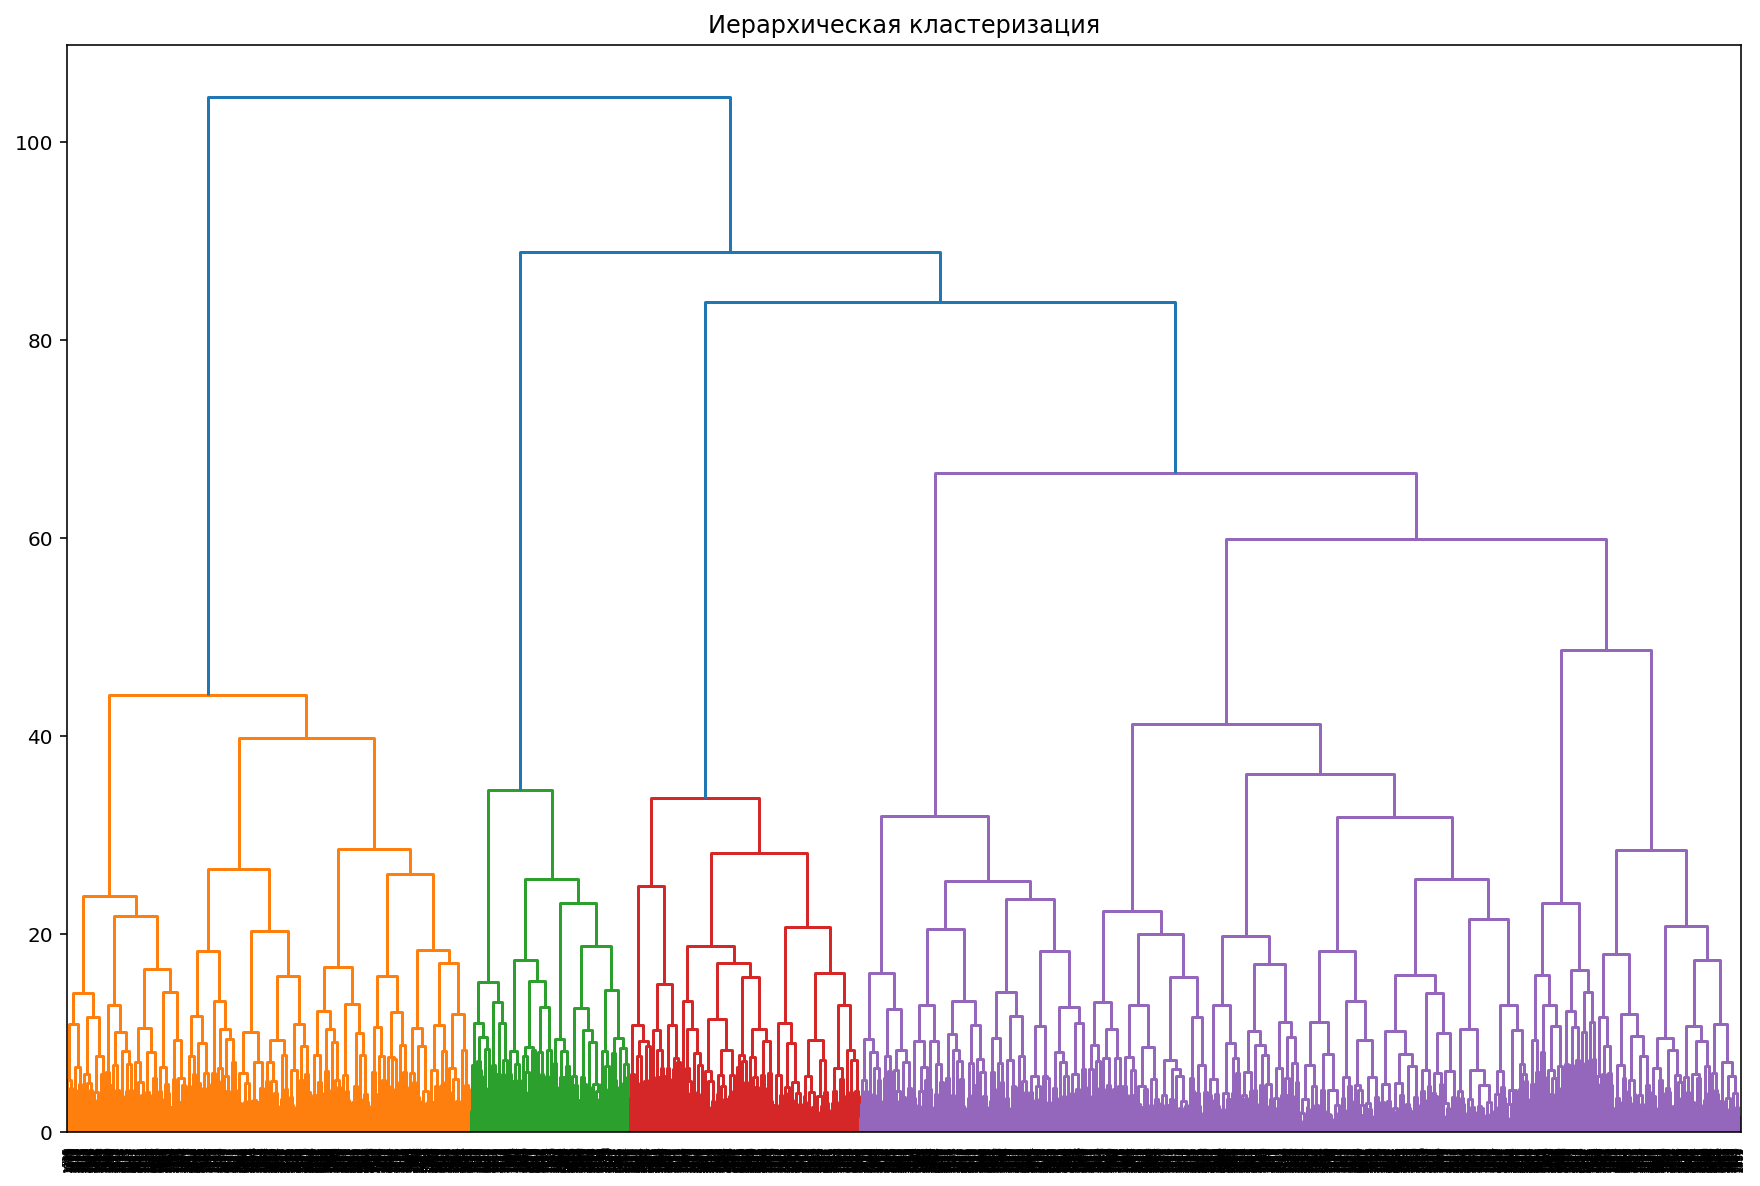

In [21]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Дендрограмма показала разделение на 4 кластера. Используем это значение для алгоритма прогнозирования `K-Means`.

Используем аглоритм **K-Means** для прогнозирования кластеров клиентов. Добавим в датафрейм столбец с присвоенными значениями кластеров.

In [22]:
km = KMeans(n_clusters=4, random_state=0) 
labels = km.fit_predict(x_sc) 

df['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.

In [23]:
df.groupby('cluster').mean().T

cluster,0,1,2,3
gender,0.52,0.49,0.54,0.50
Near_Location,0.86,0.76,0.86,0.94
Partner,0.47,0.38,0.34,0.78
Promo_friends,0.31,0.19,0.21,0.57
Phone,0.00,1.00,1.00,1.00
Contract_period,4.78,1.90,2.40,10.70
Group_visits,0.43,0.29,0.45,0.54
Age,29.30,28.05,29.99,29.91
Avg_additional_charges_total,144.21,129.70,157.36,161.36
Month_to_end_contract,4.47,1.81,2.24,9.77


In [24]:
df['cluster'].value_counts()

1    1479
3    1078
2    1057
0     386
Name: cluster, dtype: int64

Для каждого полученного кластера посчитаем долю оттока.

In [25]:
(df.groupby('cluster')['Churn'].mean()*100).apply('{:.2f}%'.format)

cluster
0    26.68%
1    55.98%
2     9.27%
3     2.97%
Name: Churn, dtype: object

Количество посетителей в кластерах заметно различается, также различаются доли оттока и средние значения признаков. Сформулируем основные характеристики кластеров.

*Кластер 0*
- доля оттока средняя (27%)
- самая малочисленная группа (386 чел.)
- не указали номер телефона
- чаще покупают абонемент на 3-6 мес. 
- посещали клуб около 2 раз в неделю

*Кластер 1*
- доля оттока самая высокая (56%)
- самая многочисленная группа (1479 чел.)
- покупали в основном краткосрочные абонементы на 1 мес.
- не использовали промокод по акции «приведи друга»
- не являются сотрудниками компании-партнёра клуба
- реже других посещают групповые занятия
- посещали клуб реще остальных, около 1 раза в неделю

*Кластер 2*
- доля оттока низкая (9%)
- включает около 27% клиентов (1057 чел.)
- обычно покупали среднесрочные абонементы на 3 мес
- посещали клуб чаще других, около 3 раз в неделю
- часто посещают групповые занятия

*Кластер 3*
- самая низкая доля оттока (3%)
- включает около 27% клиентов (1078 чел.)
- обычно покупали долгосрочные абонементы на 12 мес.
- преимущественно являются сотрудниками компании-партнёра клуба
- чаще других приходили по акции «приведи друга»
- преимущественно живут или работают рядом с клубом
- посещают клуб около 2 раз в неделю


Посчитаем метрику силуэта для нашей кластеризации

In [26]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.13


Это очень низкий показатель, что говорит о том, что кластеры накладываются друг на друга, нет четкого разделения признаков. Точечные графики в этом случае будут мало понятны. 

Построим графики распределения признаков для кластеров с помощью `kdeplot` и `countplot`.

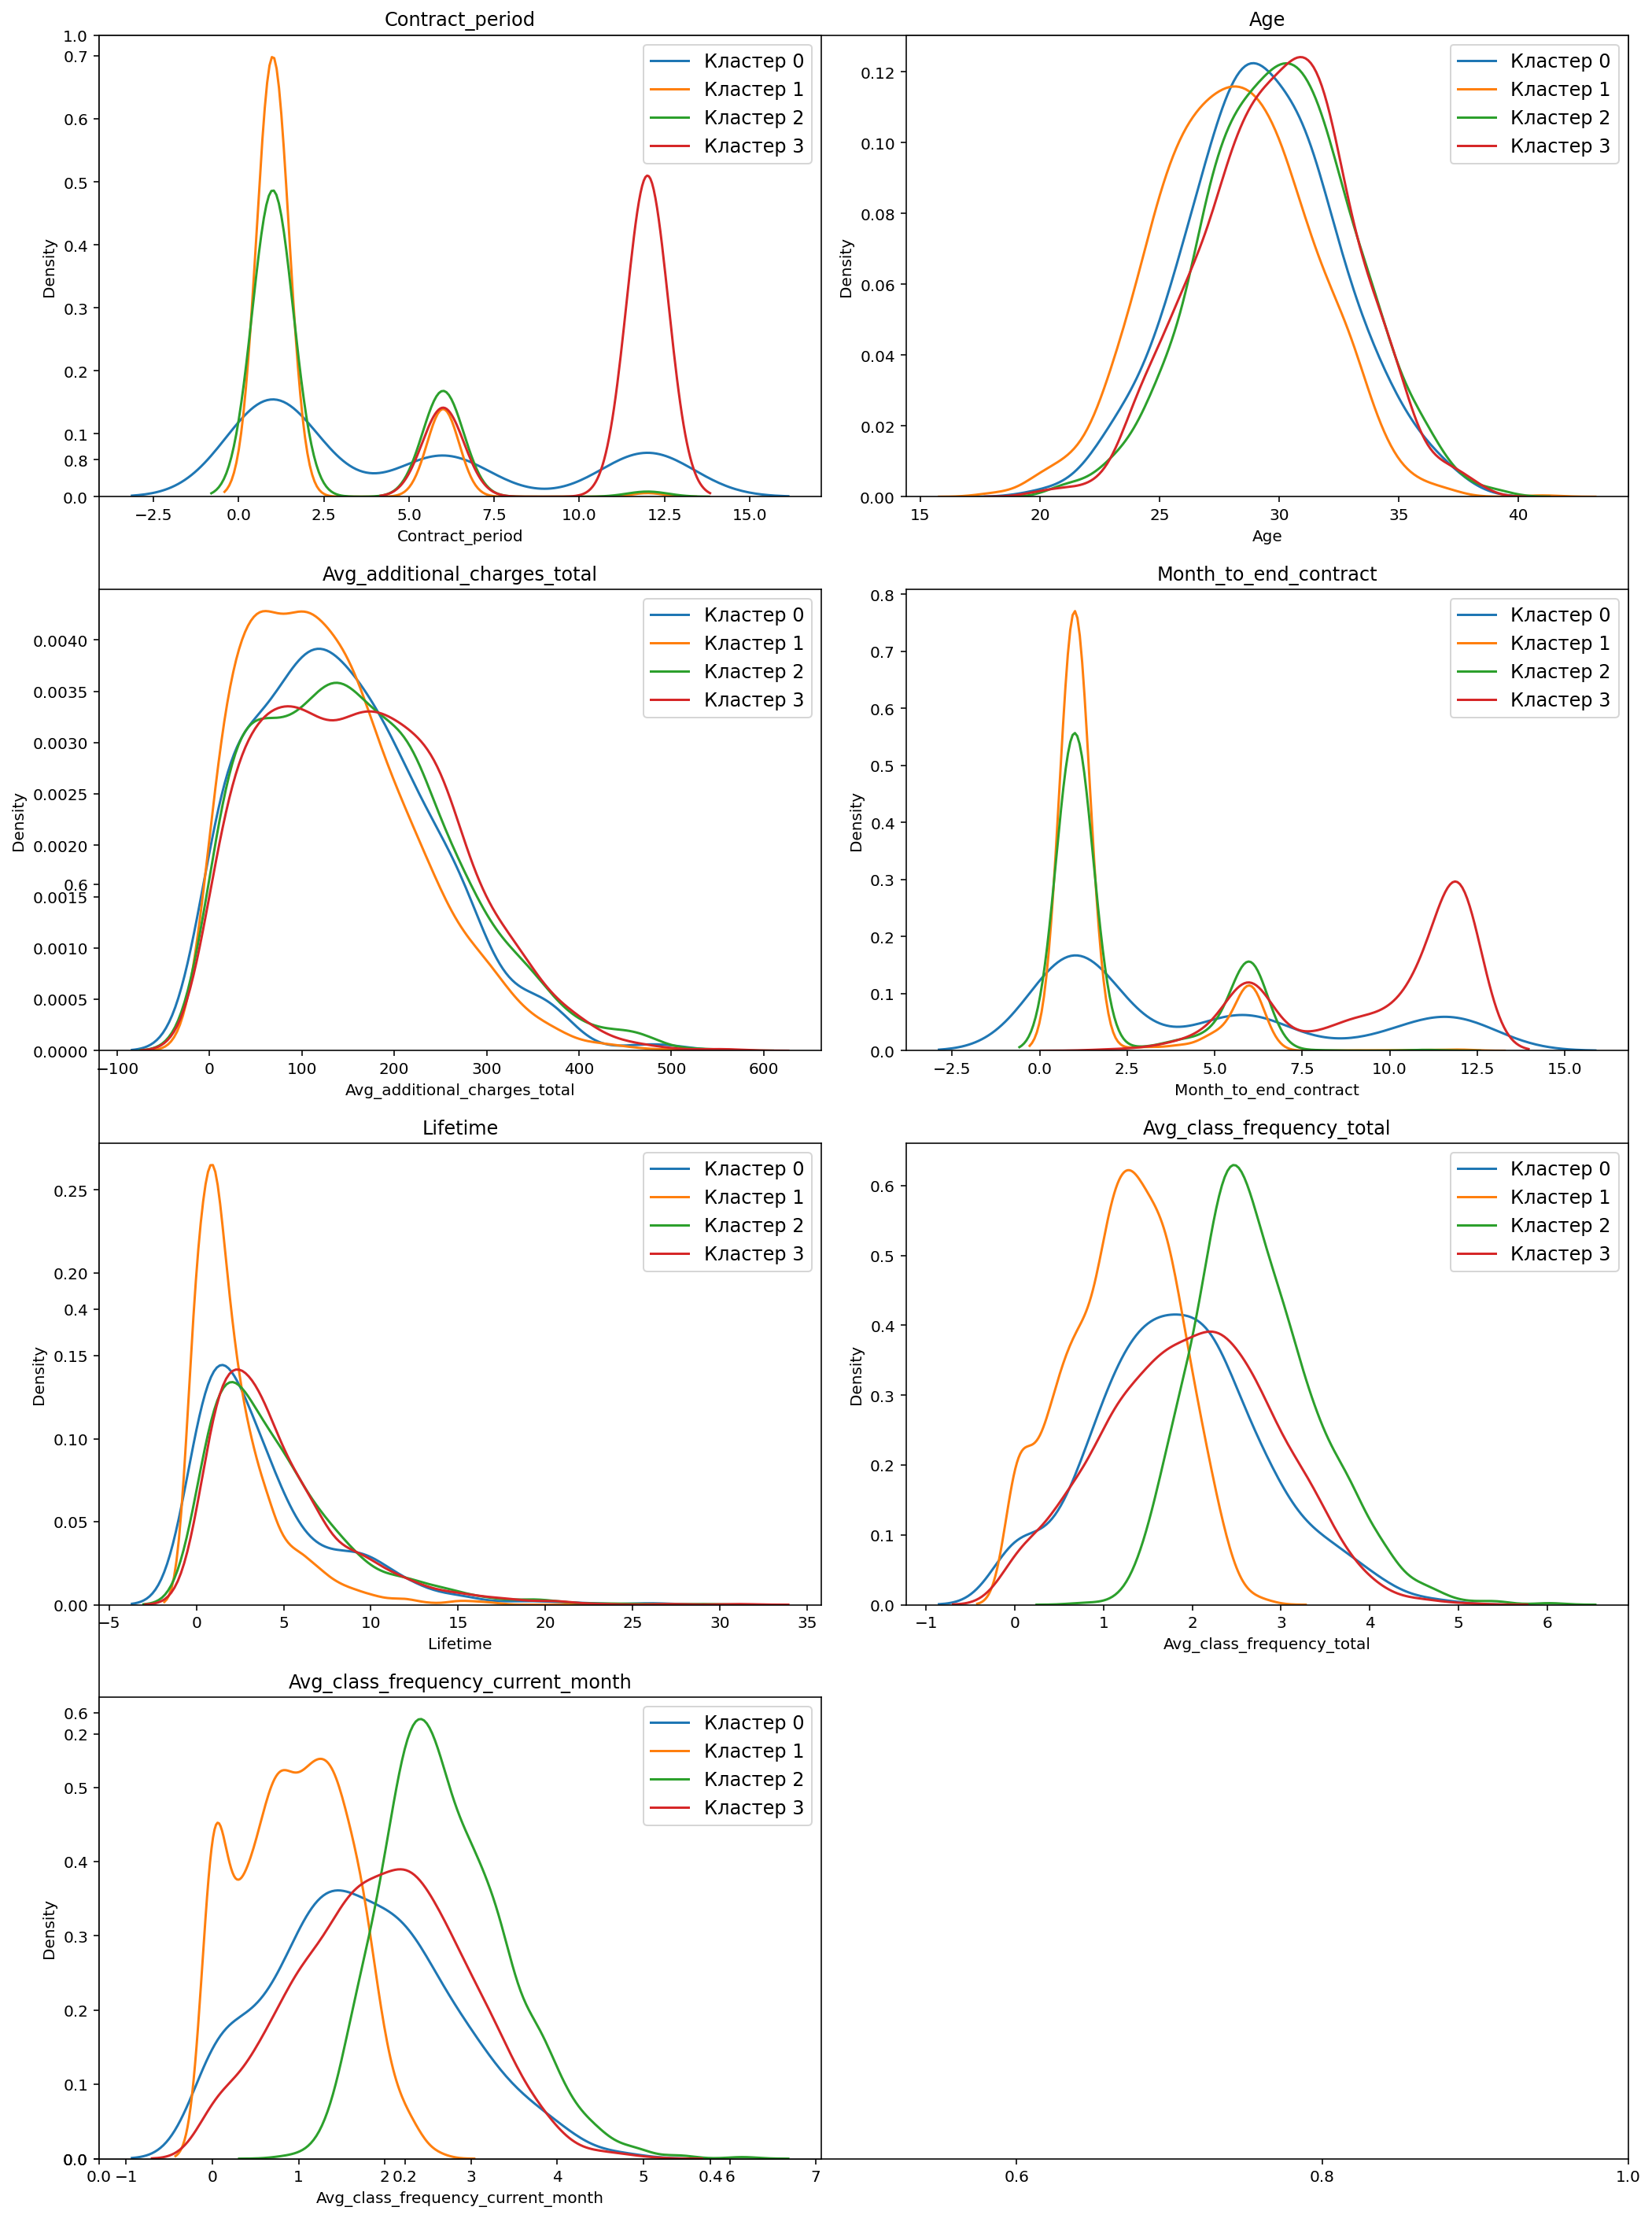

In [27]:
columns = df[['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]

fig, ax = plt.subplots(figsize = (15, 20))
for i, column in enumerate(columns):
    ax=fig.add_subplot(4, 2, i+1)
    sns.kdeplot(df[df['cluster']==0][column], ax=ax, label = 'Кластер 0')
    sns.kdeplot(df[df['cluster']==1][column], ax=ax, label = 'Кластер 1')
    sns.kdeplot(df[df['cluster']==2][column], ax=ax, label = 'Кластер 2')
    sns.kdeplot(df[df['cluster']==3][column], ax=ax, label = 'Кластер 3')
    plt.legend(fontsize = 12)
    plt.title(column)
plt.tight_layout()


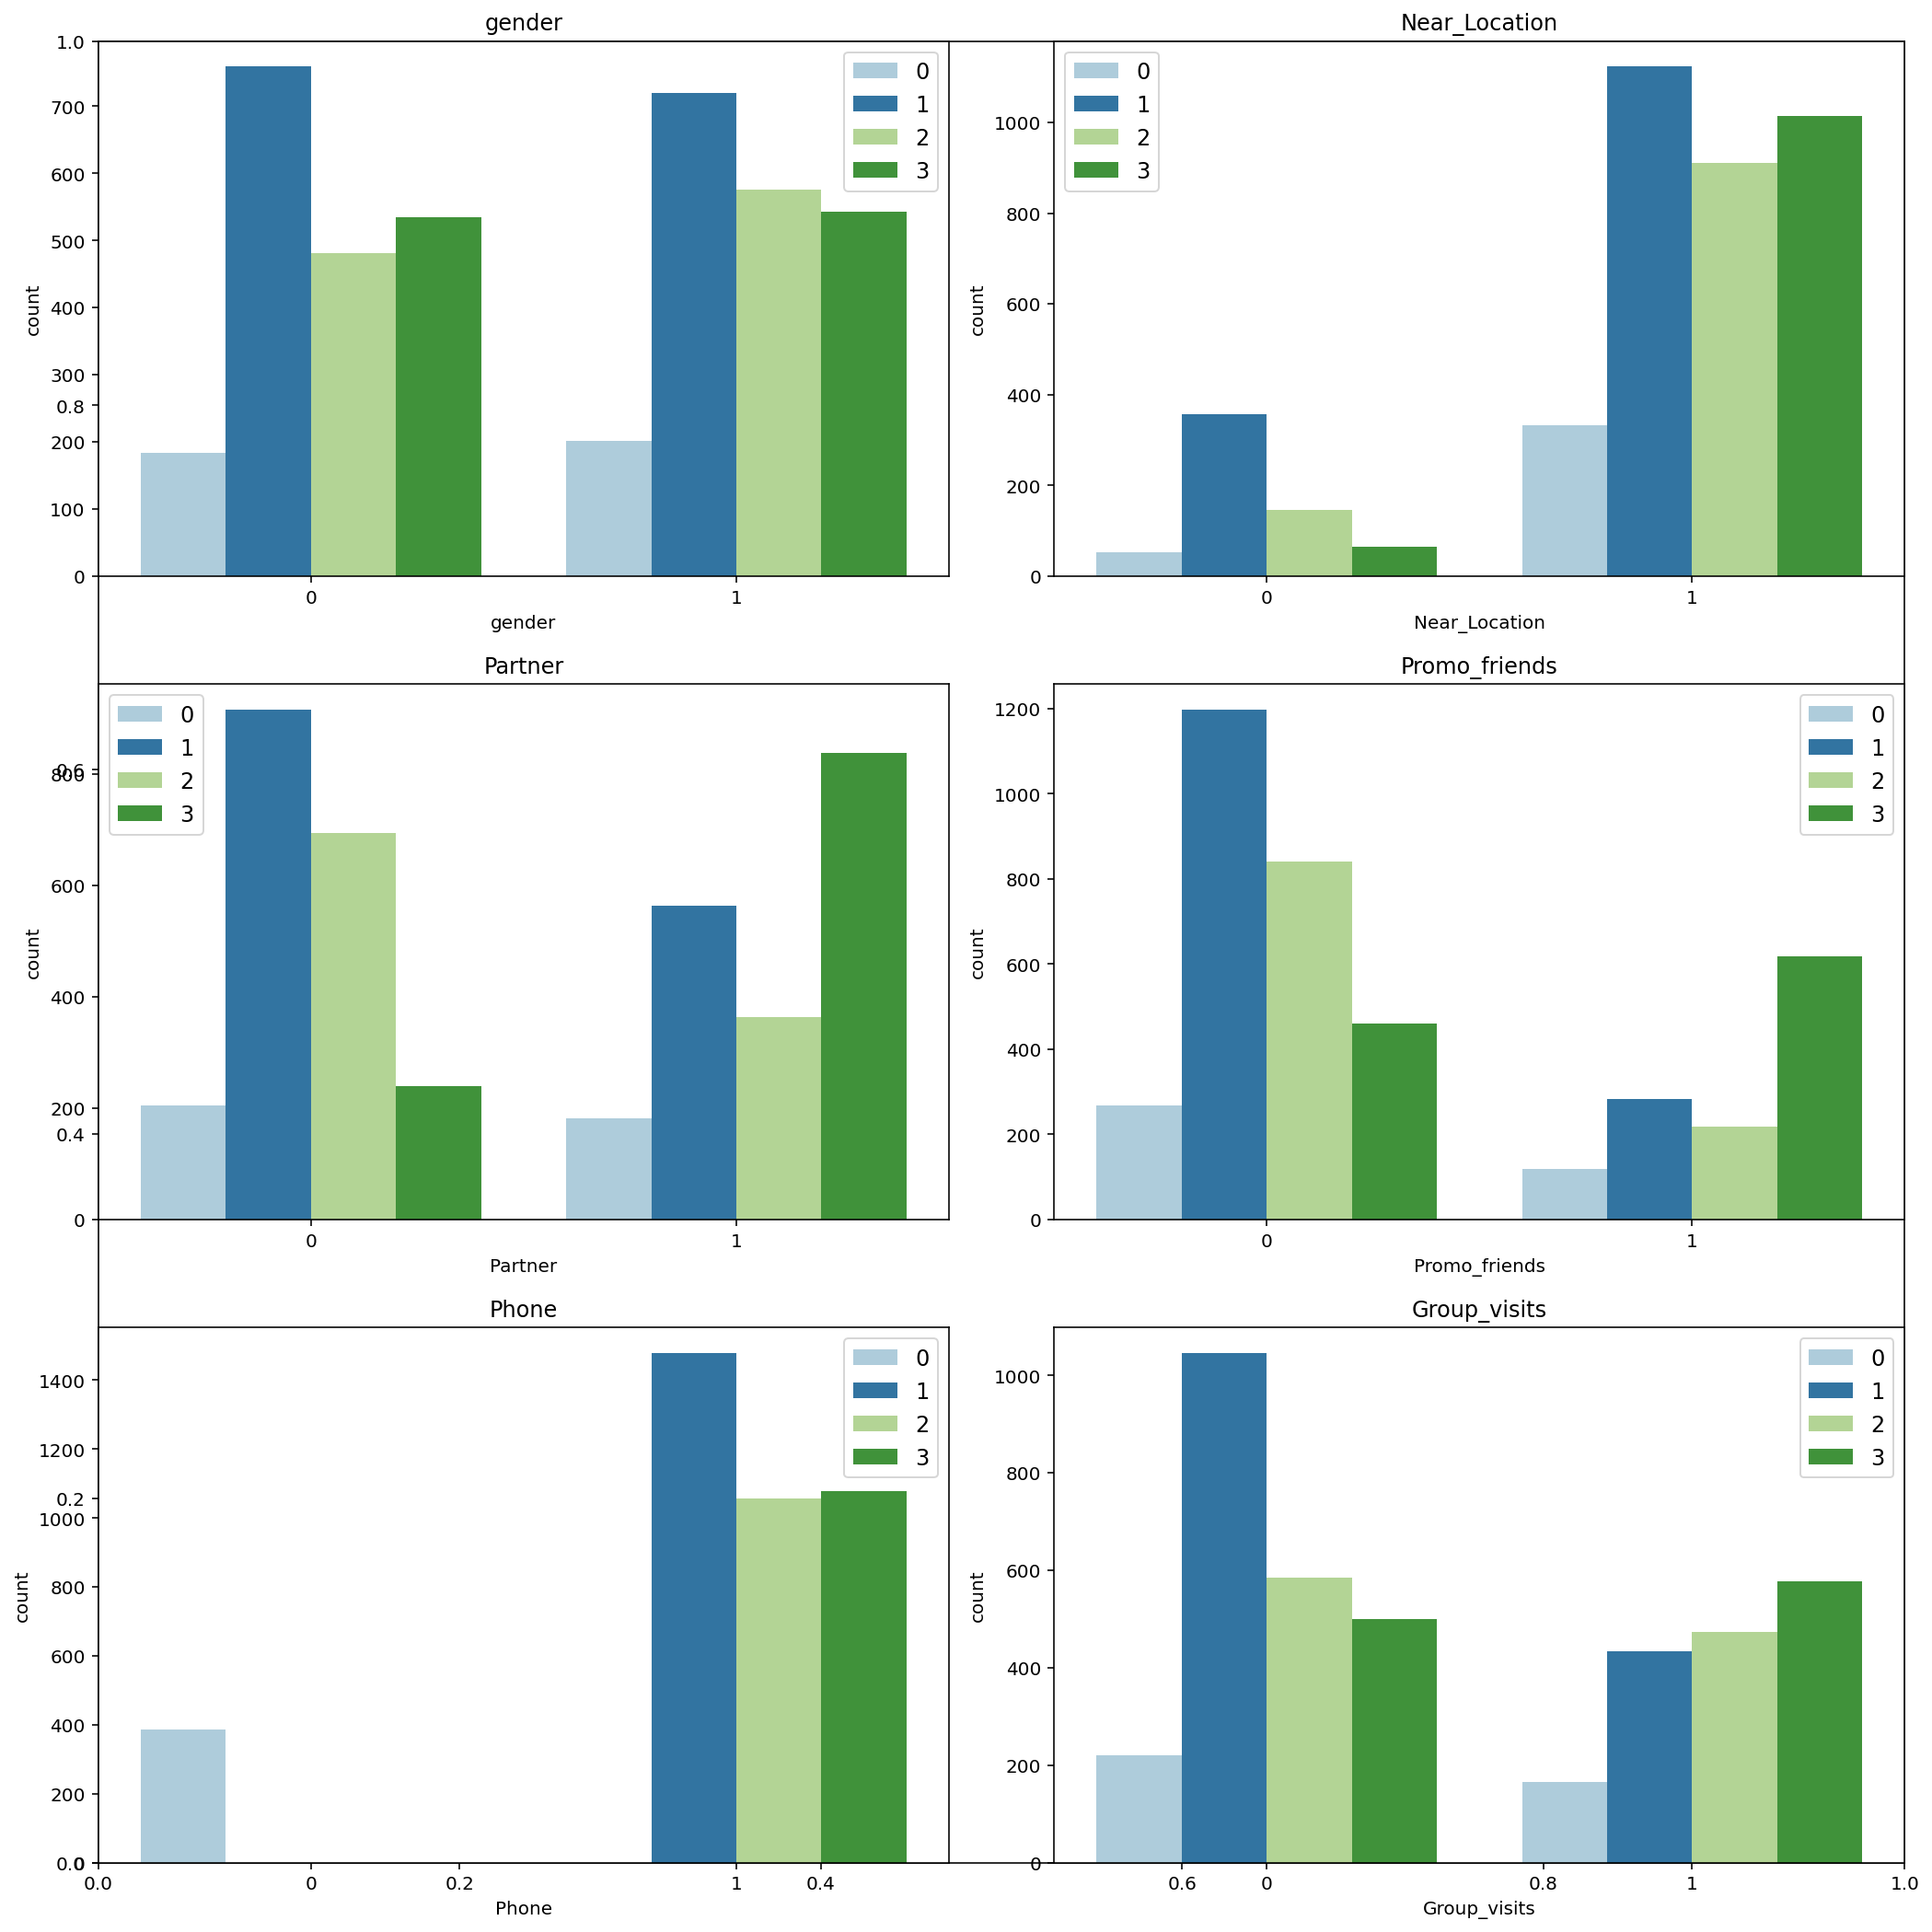

In [28]:
columns = df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']]

fig, ax = plt.subplots(figsize = (15, 15))
for i, column in enumerate(columns):
    ax=fig.add_subplot(3, 2, i+1)
    sns.countplot(x = df[column], hue='cluster', data=df, palette=sns.color_palette('Paired'))
    plt.legend(fontsize = 12)
    plt.title(column)
    
plt.tight_layout() 

**Вывод**

- Мы сформировли 4 кластера. Они не имеют ярко выраженного разделения, однако кластеры с большим и маленьким оттоком меют ряд характерных отличий. 
- Такие признаки как пол и возраст оказались наименее полезны в формировании кластеров. 


## Выводы и базовые рекомендации по работе с клиентами

Выводы:
- По итогам исследования нами была построена модель для прогнозирования оттока клиентов в следующем месяце на основе линейной регрессии с высокой степенью точности. 
- Мы сформировали 4 группы клиетов и выделили их основные характеристики. Стоит обратить внимание на группу клиентов в кластере 1, т.к. это самая многочисленная группа с самым большим оттоком. 
- Характерные черты клиентов, склонных к оттоку: работают или живут далеко от фитнес-цента, короткие абонементы, редкая посещаемость, не являются сотрдниками компаний-партнеров и не используют промокоды, короткий лайфтайм.
- Минимальный отток у кластера 3. Характерные черты группы: абонемент на длительный период, регулярное посещение занятий, в т.ч. групповых, сотрудники компаний-партнеров, длительный лайфтайм.


Рекомендации: 

- стимулировать покупки долгосрочных абонементов клиентами, которые не являются партнерами, возможно с помощью скидок, акций;
- предлагать пробные групповые занятия и занятия с тренером;
- поощрять различными бонусами клиентов, которые посещают фитнес 3 и более раз в неделю;
- увеличивать лайфтайм клиентов, для конкретных рекомендаций требуется консультация с менеджерами;
- развивать партнерскую сеть.
